In [84]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

In [85]:
end = dt.datetime.now()
start_time = end - dt.timedelta(days=300)

Estudar a volatilidade dos preços das ações, usando ATR(alcance médio verdadeiro)



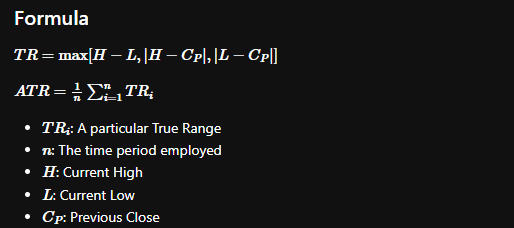

In [86]:
data = yf.download(tickers='NFLX', start=start_time, end=end)

[*********************100%***********************]  1 of 1 completed


In [87]:
def ATR(data):
  high_low = data["High"] - data['Low']
  high_cp = np.abs(data['High'] - data['Close'].shift())
  low_cp = np.abs(data['Low'] - data['Close'].shift())

  df = pd.concat([high_low, high_cp, low_cp], axis=1)

  true_range = np.max(df, axis=1)

  average_true_range = true_range.rolling(14).mean()

  return average_true_range


In [88]:
atr = ATR(data)


Text(0, 0.5, 'Price')

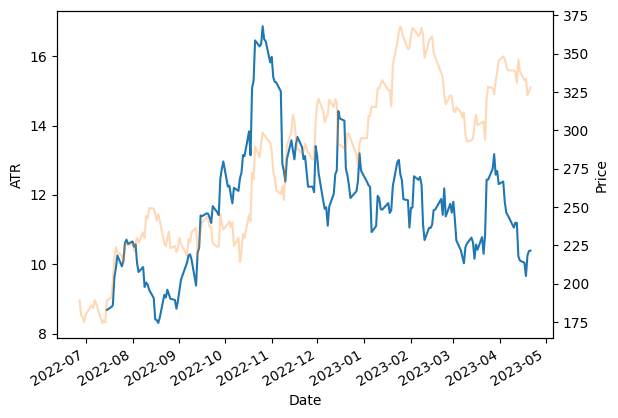

In [89]:
fig,ax = plt.subplots()
atr.plot(ax=ax)
ax2 = data['Close'].plot(ax=ax, secondary_y=True, alpha=.3)
ax.set_ylabel("ATR")
ax2.set_ylabel('Price')

#plot da volatilidade e o preço da ação no dia

Calcular o Shape Ratio (avalia a rentabilidade de um investimento em relação ao risco da aplicação financeira)

Formula:

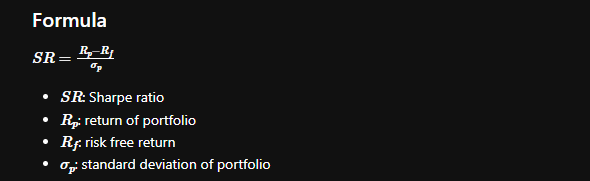

In [90]:
#portfolio escolhido
tickers=['NFLX', 'MSFT', 'IBM']
data = yf.download(tickers=tickers, start=start_time, end=end)
data = data['Adj Close']


[*********************100%***********************]  3 of 3 completed


In [91]:
portfolio = [.50, .30, .20]
portfolio = np.array(portfolio)

In [92]:
def sharpe_ratio_calc(portfolio, data):
  log_returns = np.log(data/data.shift())
  weight = portfolio
  weight /= weight.sum()
  exp_rtn = np.sum(log_returns.mean()*weight)*len(data)
  exp_vol = np.sqrt(np.dot(weight.T, np.dot(log_returns.cov()*len(data), weight)))
  sharpe_ratio = exp_rtn / exp_vol
  return sharpe_ratio, exp_rtn, exp_vol

sharpe_ratio = sharpe_ratio_calc(portfolio, data)[0]
sharpe_ratio

0.42100427106280586

Simulação de Monte Carlo

1) Calculando a melhor distribuição de ações no Portfolio

In [125]:
n = 5000
portfolio_size = 3
port_weights = np.zeros((n,portfolio_size))
exp_returns = np.zeros(n)
exp_volat = np.zeros(n)
sharpe_ratios=  np.zeros(n)

for i in range(n): ## calcula o sharpe_ratio para 5000 diferentes distribuições das ações
  weight = np.random.random(portfolio_size)
  weight /= weight.sum()
  port_weights[i] = weight
  sharpe_ratios[i], exp_returns[i], exp_volat[i] = sharpe_ratio_calc(port_weights[i], data)


In [126]:
sharpe_ratios.max()

1.2197131851882623

In [127]:
port_weights[sharpe_ratios.argmax()]

array([0.00677456, 0.00768588, 0.98553956])

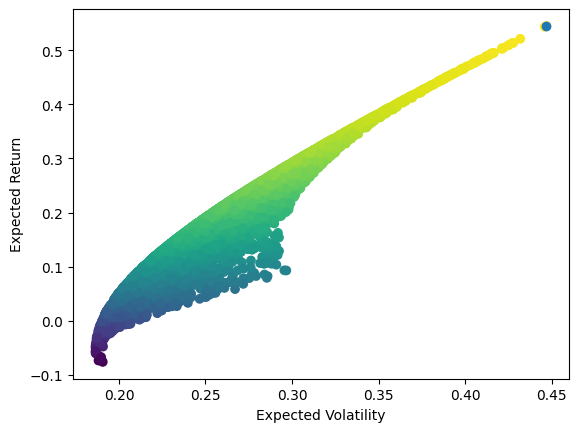

In [128]:
fig, ax = plt.subplots()
ax.scatter(exp_volat, exp_returns, c=sharpe_ratios)
ax.scatter(exp_volat[sharpe_ratios.argmax()], exp_returns[sharpe_ratios.argmax()])
ax.set_xlabel("Expected Volatility")
ax.set_ylabel('Expected Return')
plt.show()

Fazendo a simulação de Monte Carlo


In [129]:
def mean_returns(data, start, end):
  returns = data.pct_change()
  mean_returns = returns.mean()
  covMatrix = returns.cov()

  return mean_returns, covMatrix

mean_returns, covMatrix = mean_returns(data, start_time, end)

In [130]:

num_sim=200
TimeFrame = 100
meanM = np.full(shape=(TimeFrame, portfolio_size), fill_value=mean_returns)
meanM = meanM.T

portfolio_sim_matrix = np.full(shape=(TimeFrame, num_sim), fill_value=0.0)

In [132]:

initital_port =100000

for i in range(0,num_sim):
  z = np.random.normal(size=(TimeFrame, portfolio_size))
  l = np.linalg.cholesky(covMatrix)
  dailyReturns = meanM + np.inner(l, z)
  portfolio_sim_matrix[:, i] = np.cumprod(np.inner(port_weights[sharpe_ratio.argmax()], dailyReturns.T)+1)*initital_port

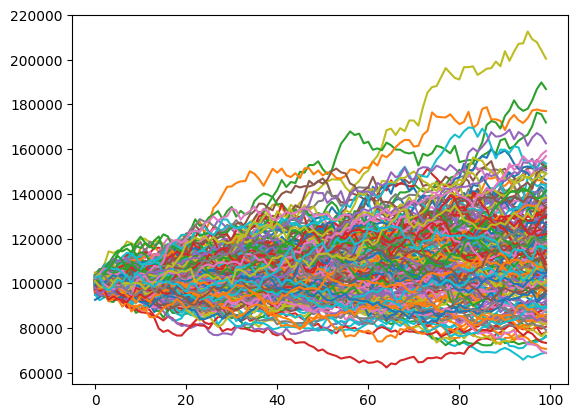

In [133]:
plt.plot(portfolio_sim_matrix)
plt.show()